# Finetuning model for Ending summarisation

In [3]:
import json
import torch
import random
import numpy as np
import pandas as pd
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Seq2SeqTrainingArguments,
    Trainer,
    DataCollatorForSeq2Seq,
)
from peft import LoraConfig, get_peft_model, PeftModel, PeftConfig
from bert_score import score
import evaluate
import os
import matplotlib.pyplot as plt
import nltk

# Make sure the required NLTK data packages are available
# Dynamically construct NLTK data directory relative to current working directory
nltk_data_dir = os.path.join(os.getcwd(), "venv", "nltk_data")

# Create directory if it doesn't exist
os.makedirs(nltk_data_dir, exist_ok=True)

nltk.download("punkt", download_dir=nltk_data_dir)
nltk.download('punkt_tab', download_dir=nltk_data_dir)
nltk.download("stopwords", download_dir=nltk_data_dir)

[nltk_data] Downloading package punkt to d:\Keven(Work)\dsa4213\final
[nltk_data]     project\venv\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     d:\Keven(Work)\dsa4213\final project\venv\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     d:\Keven(Work)\dsa4213\final project\venv\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# set seed for reproducibility
def set_seed(seed=4213):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(4213)

In [5]:
# Config
# ==============================
TRAIN_FILE = "stories_with_outlines_first3000.jsonl"
OUTPUT_DIR = "./Ending-summariser-LoRA-v2"
BASE_MODEL = "t5-small"
BASE_MODEL2 = "google/flan-t5-base"
USE_LORA = True
MAX_INPUT_LENGTH = 512
MAX_TARGET_LENGTH = 128
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Data preprocessing

In [6]:
# Read in raw data

print(f"Loading each event dataset: {TRAIN_FILE}")
# Read all lines as JSON
raw_data = []
with open(TRAIN_FILE, "r", encoding="utf-8") as f:
    for line in f:
        each_line = json.loads(line)
        # extract story text and reformat input
        story = each_line['story']
        prompt = "Extract the ending for this text:\n" 
        final_input = prompt + story
        # extract outline details: ending
        outline = each_line['outline']
        ending = outline['ending'].get('summary')

        # append to dataset
        raw_data.append({"instruction": final_input, "response": ending})

raw_data[:5]  # preview first 5 entries 

Loading each event dataset: stories_with_outlines_first3000.jsonl


[{'instruction': 'Extract the ending for this text:\nOnce upon a time, in a warm and sunny place, there was a big pit. A little boy named Tom liked to play near the pit. One day, Tom lost his red ball. He was very sad.\nTom asked his friend, Sam, to help him search for the ball. They looked high and low, but they could not find the ball. Tom said, "I think my ball fell into the pit."\nSam and Tom went close to the pit. They were scared, but they wanted to find the red ball. They looked into the pit, but it was too dark to see. Tom said, "We must go in and search for my ball."\nThey went into the pit to search. It was dark and scary. They could not find the ball. They tried to get out, but the pit was too deep. Tom and Sam were stuck in the pit. They called for help, but no one could hear them. They were sad and scared, and they never got out of the pit.',
  'response': 'Tom and Sam remain trapped in the pit, feeling hopeless and frightened.'},
 {'instruction': 'Extract the ending for t

In [7]:
dataset = Dataset.from_list(raw_data)
dataset = dataset.train_test_split(test_size=0.01)
dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'response'],
        num_rows: 2970
    })
    test: Dataset({
        features: ['instruction', 'response'],
        num_rows: 30
    })
})

In [8]:
# Prepare tokenizer and model
print(f"Loading base model: {BASE_MODEL}")
base_model = AutoModelForSeq2SeqLM.from_pretrained(BASE_MODEL).to(DEVICE)
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)

Loading base model: t5-small


In [9]:
# Preprocessing function
def preprocess_function(batch):
    model_inputs = tokenizer(
        batch["instruction"],
        max_length=MAX_INPUT_LENGTH,
        padding="max_length",
        truncation=True,
    )
    labels = tokenizer(
        text_target=batch["response"],
        max_length=MAX_TARGET_LENGTH,
        padding="max_length",
        truncation=True,
        )  
    # Replace pad token IDs with -100 so they’re ignored in cross-entropy loss
    labels["input_ids"] = [
        [(token if token != tokenizer.pad_token_id else -100) for token in label]
        for label in labels["input_ids"]
    ]
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Tokenize the dataset
tokenized_dataset = dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=["instruction", "response"],
    desc="Tokenizing dataset",
)

Tokenizing dataset: 100%|██████████| 30/30 [00:00<00:00, 999.93 examples/s]


In [10]:
# Test current model with zero shot inference
from torch import no_grad

# use one example from test set
story = dataset['test'][22]["instruction"]
ending = dataset['test'][22]["response"]

# Tokenise input
inputs = tokenizer(story, return_tensors="pt", max_length=MAX_INPUT_LENGTH, truncation=True).to(DEVICE)
# Generate output and decode
with no_grad():
    outputs = base_model.generate(
        **inputs,
        max_new_tokens=MAX_TARGET_LENGTH,
        num_beams=4,
        early_stopping=True
    )
base_output = tokenizer.decode(outputs[0], skip_special_tokens=True)

dashline = "-" * 80
print(dashline)
print("Story:")
print(story)
print(dashline)
print("Expected ending:")  
print(ending)
print(dashline)
print("Model Output ending:")
print(base_output)
print(dashline)

--------------------------------------------------------------------------------
Story:
Extract the ending for this text:
Once there was a very curious little kitten. One day, she was walking when she heard a strange noise. She looked around but she couldn't find where the noise was coming from. Suddenly, she saw a boy stretching on the grass. The curious little kitten went closer to take a look.
The boy noticed her and said, "Hi little kitten! How are you?" The little kitten meowed in reply.
The boy continued, "Let me tell you something important. Whenever we are feeling down or in bad mood, we can try stretching. It will help us feel better." Then the boy demonstrated some stretches.
The little kitten was amazed! She copied the boy and began stretching. Suddenly, she felt much better.
The little kitten said goodbye to the boy with a meow. She understood the moral of the story: when you are feeling down, try stretching and you will be able to feel better too!
-------------------------

# PEFT model using LoRA
(skip the cells in this section if not finetuning)

In [10]:
# LoRA configuration
if USE_LORA:
    print("Applying LoRA adapter for lightweight fine-tuning...")
    lora_config = LoraConfig(
        r=32,
        lora_alpha=128,
        target_modules=["q", "v"],
        lora_dropout=0.05,
        bias="none",
        task_type="SEQ_2_SEQ_LM",
    )
lora_model = get_peft_model(base_model, lora_config)
lora_model.print_trainable_parameters()

print(f"Using device: {DEVICE}")
lora_model = lora_model.to(DEVICE)

# PEFT Training configuration
peft_training_args = Seq2SeqTrainingArguments(
    output_dir=OUTPUT_DIR,
    auto_find_batch_size=True,
    gradient_accumulation_steps=4,
    num_train_epochs=5,
    learning_rate=3e-5,
    fp16=torch.cuda.is_available(),
    predict_with_generate=True,
    report_to="none",  # disable wandb/tensorboard
    save_strategy="steps",  
    save_steps=50,          
    save_total_limit=3,     
    logging_strategy="epoch",
)

# Data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=lora_model
)

# PEFT Trainer setup
peft_trainer = Trainer(  
    model=lora_model,
    args=peft_training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    data_collator=data_collator,
    processing_class=tokenizer,
)

Applying LoRA adapter for lightweight fine-tuning...
trainable params: 1,179,648 || all params: 61,686,272 || trainable%: 1.9123
Using device: cuda


In [11]:
# Initiate training

print("Starting training...")
# Resume only if checkpoint exists
resume_checkpoint = None
last_checkpoint_dir = os.path.join(OUTPUT_DIR, "checkpoint-last")
if os.path.isdir(last_checkpoint_dir):
    resume_checkpoint = last_checkpoint_dir
    print(f"Resuming from checkpoint: {resume_checkpoint}")
else:
    print("No existing checkpoint found — starting fresh training.")

# Else start training
peft_trainer.train(resume_from_checkpoint=resume_checkpoint)

# Save the final model with training logs
print(f"Saving LoRA fine-tuned model to {OUTPUT_DIR}")
lora_model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
peft_trainer.save_state()

Starting training...
No existing checkpoint found — starting fresh training.


Step,Training Loss
93,2.943900
186,2.463100
279,2.298400
372,2.238400
465,2.203500


Saving LoRA fine-tuned model to ./Ending-summariser-LoRA-v2


# Models Testing and Comparison

In [11]:
# Now we can test and compare the models on the same example
def load_model_for_inference(directory, device=DEVICE):
    if directory==BASE_MODEL or BASE_MODEL2:
        model = AutoModelForSeq2SeqLM.from_pretrained(directory)
        tokenizer = AutoTokenizer.from_pretrained(directory)
    else:
        config = PeftConfig.from_pretrained(directory)
        base_model = AutoModelForSeq2SeqLM.from_pretrained(config.base_model_name_or_path)
        model = PeftModel.from_pretrained(base_model, directory)
        tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)
    model = model.to(device)
    model.eval()  # ensure inference mode
    print(f"Loaded {directory} on device: {device}")
    return model, tokenizer

# function to generate outputs
def generate_output(text_input, model, tokenizer, device=DEVICE):
    # generate input
    inputs = tokenizer(text_input, return_tensors="pt").to(device)
    # then generate output
    with torch.inference_mode():
        output = tokenizer.decode(
        model.generate(**inputs, max_new_tokens=MAX_TARGET_LENGTH)[0],
        skip_special_tokens=True
    )
    return output

t5_small, t5s_tokenizer = load_model_for_inference(BASE_MODEL)
flan_t5, ft5_tokenizer = load_model_for_inference(BASE_MODEL2)
lora_v1, lv1_tokenizer = load_model_for_inference("./Ending-summariser-LoRA-v1")
lora_v2, lv2_tokenizer = load_model_for_inference("./Ending-summariser-LoRA-v2")

Loaded t5-small on device: cuda
Loaded google/flan-t5-base on device: cuda
Loaded ./Ending-summariser-LoRA-v1 on device: cuda
Loaded ./Ending-summariser-LoRA-v2 on device: cuda


In [12]:
# Display summaries
print("-" * 100)
print("Actual Text:")
print(story)
print("-" * 100)
print("Expected summary:")  
print(ending)
print("-" * 100)
print("t5_small Output summary:")
print(generate_output(story, t5_small, t5s_tokenizer))
print("-" * 100)
print("flan_t5 Output summary:")
print(generate_output(story, flan_t5, ft5_tokenizer))
print("-" * 100)
print("lora_v1 Output summary:")
print(generate_output(story, lora_v1, lv1_tokenizer))
print("-" * 100)
print("lora_v2 Output summary:")
print(generate_output(story, lora_v2, lv2_tokenizer))
print("-" * 100)


----------------------------------------------------------------------------------------------------
Actual Text:
Extract the ending for this text:
Once there was a very curious little kitten. One day, she was walking when she heard a strange noise. She looked around but she couldn't find where the noise was coming from. Suddenly, she saw a boy stretching on the grass. The curious little kitten went closer to take a look.
The boy noticed her and said, "Hi little kitten! How are you?" The little kitten meowed in reply.
The boy continued, "Let me tell you something important. Whenever we are feeling down or in bad mood, we can try stretching. It will help us feel better." Then the boy demonstrated some stretches.
The little kitten was amazed! She copied the boy and began stretching. Suddenly, she felt much better.
The little kitten said goodbye to the boy with a meow. She understood the moral of the story: when you are feeling down, try stretching and you will be able to feel better too!

# Evaluation using ROGUE + BERT scores

In [13]:
# prepare the eval dataset to be used for rouge evaluation
original_summaries = []
base_model1_predictions = []
base_model2_predictions = []
lora1_model_predictions = []
lora2_model_predictions = []

print("Generating predictions...")
for item in dataset['test']:    # replace test_subset with eval_data
    # original summary list
    original_summaries.append(item["response"])
    # predictions
    base1_output = generate_output(item["instruction"], t5_small, t5s_tokenizer)
    base_model1_predictions.append(base1_output)
    base2_output = generate_output(item["instruction"], flan_t5, ft5_tokenizer)
    base_model2_predictions.append(base2_output)
    lora1_output = generate_output(item["instruction"], lora_v1, lv1_tokenizer)
    lora1_model_predictions.append(lora1_output)
    lora2_output = generate_output(item["instruction"], lora_v2, lv2_tokenizer)
    lora2_model_predictions.append(lora2_output)

Generating predictions...


In [14]:
# combine into dataframe
df = pd.DataFrame({
    "Original Summary": original_summaries,
    "t5-small Prediction": base_model1_predictions,
    "flan-t5-base Prediction": base_model2_predictions,
    "LoRA-v1 Model Prediction": lora1_model_predictions,
    "LoRA-v2 Model Prediction": lora2_model_predictions
})

df.head(5)

,Original Summary,t5-small Prediction,flan-t5-base Prediction,LoRA-v1 Model Prediction,LoRA-v2 Model Prediction
0,The man's perseverance and the advice from his...,: the wall. the wall. He was so tired he could...,The man was proud of his work.,True,The man's strength and enduring the tiredness ...
1,Tom and his friends experience joy from both t...,:: Tom and his friends saved the cat. They wer...,Tom and his friends made a film together.,True,Tom and his friends saved the cat.
2,"Mia's passion for painting grows, inspiring he...",Mia was happy with her original painting. She ...,Mia was happy with her painting.,True,"Mia's life has changed, making the world a mor..."
3,The family leaves the ranch happily with their...,",, and they went to an expensive ranch in the ...",The family went home happy.,True,The family and the Mom enjoy their time here.
4,Lily commits to helping others and being kind ...,:: her mom was making a thin mattress for her ...,Lily and her mom were proud of their work.,True,Lily and her mom learned that helping others a...


In [15]:
# Perform ROUGE evaluation
def compute_rouge_score(predictions, references):
    rouge = evaluate.load("rouge")
    results = rouge.compute(
        predictions=predictions, 
        references=references,
        use_aggregator=True,
        use_stemmer=True,
    )
    return results

# Clean text for fair comparison
original_summaries = [s.strip().lower() for s in original_summaries]
base_model1_predictions = [p.strip().lower() for p in base_model1_predictions]
base_model2_predictions = [p.strip().lower() for p in base_model2_predictions]
lora_model1_predictions = [p.strip().lower() for p in lora1_model_predictions]
lora_model2_predictions = [p.strip().lower() for p in lora2_model_predictions]

# Compute ROUGE scores
base_model1_results = compute_rouge_score(base_model1_predictions, original_summaries)
base_model2_results = compute_rouge_score(base_model2_predictions, original_summaries)
lora1_model_results = compute_rouge_score(lora1_model_predictions, original_summaries)
lora2_model_results = compute_rouge_score(lora2_model_predictions, original_summaries)

all_results = {
    "t5-small Model": base_model1_results,
    "flan-t5-base Model": base_model2_results,
    "LoRA-v1 Model": lora1_model_results,
    "LoRA-v2 Model": lora2_model_results
}

# Compare relative percentage differences in rouge scores over base model
def display_percentage_difference(base_results, new_results, model_name):
    print(f"Relative Percentage Differences in ROUGE scores for {model_name} over Base Model:")
    for key in base_results.keys():
        base_score = base_results[key] * 100  # convert to percentage
        new_score = new_results[key] * 100  # convert to percentage
        relative_diff = ((new_score - base_score) / base_score) * 100
        print(f"{key}: {relative_diff:.2f}%")
    print(dashline)

#display_percentage_difference(base_model_results, lora1_model_results, "LoRA-v1 Model")
#display_percentage_difference(base_model_results, lora2_model_results, "LoRA-v2 Model")

In [16]:
print("ROUGE scores for various models against actual endings:")
results_df = pd.DataFrame.from_dict(all_results, orient='index')
results_df.head()

ROUGE scores for various models against actual endings:


,rouge1,rouge2,rougeL,rougeLsum
t5-small Model,0.207889,0.060395,0.165291,0.165990
flan-t5-base Model,0.283650,0.083504,0.242818,0.242056
LoRA-v1 Model,0.112341,0.035808,0.099764,0.098289
LoRA-v2 Model,0.385434,0.161655,0.361942,0.361789


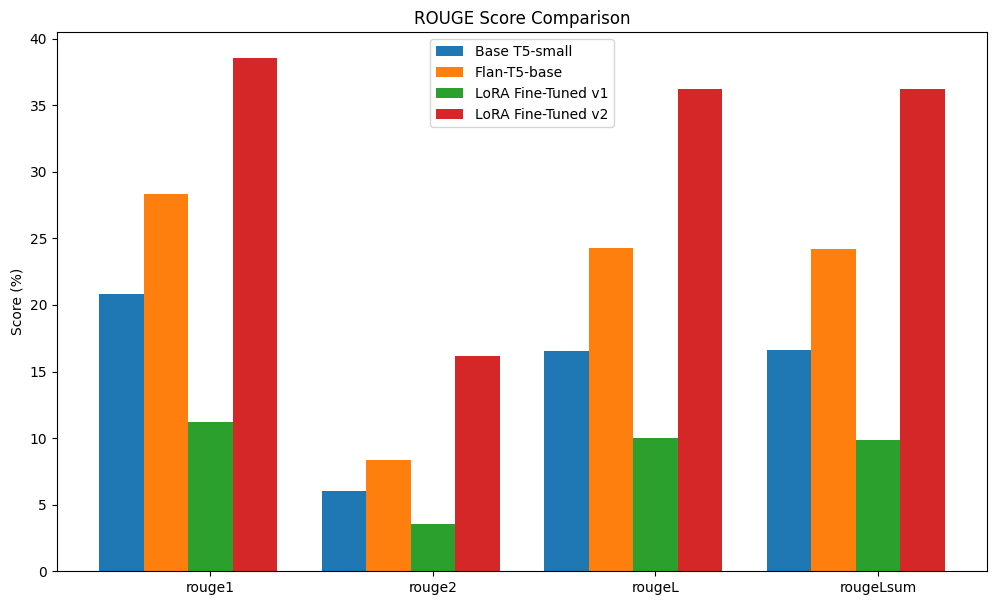

In [17]:
# Plot visuals
keys = list(base_model1_results.keys())
base1_vals = [base_model1_results[k] * 100 for k in keys]
base2_vals = [base_model2_results[k] * 100 for k in keys]
lora1_vals = [lora1_model_results[k] * 100 for k in keys]
lora2_vals = [lora2_model_results[k] * 100 for k in keys]

x = np.arange(len(keys))  # the label locations
width = 0.2             # width of each bar

plt.figure(figsize=(12, 7))
plt.bar(x - width*2, base1_vals, width, label='Base T5-small')
plt.bar(x - width, base2_vals, width, label='Flan-T5-base')
plt.bar(x , lora1_vals, width, label='LoRA Fine-Tuned v1')
plt.bar(x + width, lora2_vals, width, label='LoRA Fine-Tuned v2')

plt.xticks(x, keys)
plt.title('ROUGE Score Comparison')
plt.ylabel('Score (%)')
plt.legend()
plt.show()

In [24]:
# Now evaluate using BERT score
def compute_bert_score(predictions, references):
    P, R, F1 = score(predictions, references, model_type="roberta-large" ,lang="en", verbose=True)
    return {
        "precision": P.mean().item(),
        "recall": R.mean().item(),
        "f1": F1.mean().item()
    }

base_model1_bert = compute_bert_score(base_model1_predictions, original_summaries)
base_model2_bert = compute_bert_score(base_model2_predictions, original_summaries)
lora1_model_bert = compute_bert_score(lora1_model_predictions, original_summaries)
lora2_model_bert = compute_bert_score(lora2_model_predictions, original_summaries)

all_berts = {
    "t5-small Model": base_model1_bert,
    "flan-t5-base Model": base_model2_bert,
    "LoRA-v1 Model": lora1_model_bert,
    "LoRA-v2 Model": lora2_model_bert
}

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 90.94it/s]


done in 0.66 seconds, 45.58 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:00<00:00,  6.85it/s]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 99.90it/s]

done in 0.16 seconds, 188.48 sentences/sec



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 111.13it/s]


done in 0.56 seconds, 53.80 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 111.12it/s]

done in 0.21 seconds, 140.73 sentences/sec


In [27]:
print("BERT scores for predictions against actual endings:")
bert_df = pd.DataFrame.from_dict(all_berts, orient='index')
bert_df.head()

BERT scores for predictions against actual endings:


,precision,recall,f1
t5-small Model,0.844834,0.880060,0.861993
flan-t5-base Model,0.914909,0.883589,0.898881
LoRA-v1 Model,0.853747,0.839858,0.846636
LoRA-v2 Model,0.911584,0.895932,0.903605
